<a href="https://colab.research.google.com/github/ndb796/StyleGAN-Embedding-PyTorch/blob/main/Multiple_Face_Images_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Download the pre-trained StyleGAN weights</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting
%cd PyTorch-StyleGAN-Face-Editting
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'PyTorch-StyleGAN-Face-Editting'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 112 (delta 24), reused 43 (delta 1), pack-reused 30
Receiving objects: 100% (112/112), 95.16 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/PyTorch-StyleGAN-Face-Editting
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


#### <b>Download celebrity face images</b>

In [2]:
!git clone https://github.com/ndb796/StyleGAN-Embedding-PyTorch
!cp -r StyleGAN-Embedding-PyTorch/aligned_images/ aligned_images/

Cloning into 'StyleGAN-Embedding-PyTorch'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 84 (delta 13), reused 60 (delta 5), pack-reused 0
Unpacking objects: 100% (84/84), done.


#### <b>Load required libraries</b>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

#### <b>Load StyleGAN model</b>

In [4]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

#### <b>Define utilities</b>

In [6]:
# Read an image from a file
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f:
        image = Image.open(f)
        image = image.convert("RGB")
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1]
    ])
    image = transform(image)
    return image


# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

#### <b>Embedding functions</b>

In [7]:
import warnings
warnings.filterwarnings(action='ignore')


# VGG feature extractor
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1)

        extractor = models.vgg16(pretrained=True).features

        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = (x - self.mean) / self.std

        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

In [8]:
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image)

    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i])

    return mse_loss, perceptual_loss

#### <b>Read all images</b>

In [10]:
import os
import torch.utils.data as data


class CustomDataset(data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.images[idx])
        image_name = self.images[idx].split('.')[0]
        return image_reader(image_path), image_name


my_dataset = CustomDataset('./aligned_images')
train_loader = data.DataLoader(my_dataset , batch_size=8, shuffle=False, num_workers=4)

#### <b>Embedding experiments</b>

In [11]:
for step, (images, names) in enumerate(train_loader):
    images = images.to(device)

    latents = torch.zeros((images.shape[0], 18, 512), requires_grad=True, device=device) # latent vector
    optimizer_latent = optim.Adam({latents}, lr=0.01, betas=(0.9, 0.999), eps=1e-8)

    # VGG perceptual loss
    feature_extractor = FeatureExtractor(n_layers=[7, 14]).to(device)

    # Start the optimization
    iteration = 1000
    for i in range(iteration):
        optimizer_latent.zero_grad()

        # generate an image from a latent vector
        generated_images = g_synthesis(latents)
        generated_images = (generated_images + 1.0) / 2.0
        generated_images = generated_images.clamp(0, 1)

        loss = 0
        mse_loss, perceptual_loss = loss_function(generated_images, images, feature_extractor)
        loss += mse_loss + perceptual_loss
        loss.backward() # calculate the gradient

        optimizer_latent.step() # update the latent vector

        if i == 0 or (i + 1) % 100 == 0:
            print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}')
            for j in range(images.shape[0]):
                save_image(generated_images[j], f'{names[j]}_iter_{i + 1}.png')
                np.save(f'{names[j]}_latent.npy', latents[j].detach().cpu().numpy())

    print(f"[ Step #{step + 1} Embedding Complete ]")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



[iter 1/1000] loss = 127.55654907226562
[iter 100/1000] loss = 42.54530334472656
[iter 200/1000] loss = 34.429752349853516
[iter 300/1000] loss = 31.025928497314453
[iter 400/1000] loss = 28.65142250061035
[iter 500/1000] loss = 26.91965103149414
[iter 600/1000] loss = 26.088911056518555
[iter 700/1000] loss = 24.25936508178711
[iter 800/1000] loss = 23.966291427612305
[iter 900/1000] loss = 23.02628517150879
[iter 1000/1000] loss = 22.402790069580078
[ Step #1 Embedding Complete ]
[iter 1/1000] loss = 125.9195327758789
[iter 100/1000] loss = 49.064205169677734
[iter 200/1000] loss = 43.294376373291016
[iter 300/1000] loss = 38.40346908569336
[iter 400/1000] loss = 34.8204231262207
[iter 500/1000] loss = 33.826717376708984
[iter 600/1000] loss = 33.15054702758789
[iter 700/1000] loss = 30.746179580688477
[iter 800/1000] loss = 29.825716018676758
[iter 900/1000] loss = 29.521902084350586
[iter 1000/1000] loss = 28.369152069091797
[ Step #2 Embedding Complete ]


#### <b>Face morphing experiments</b>

[ Face Interpolation ]


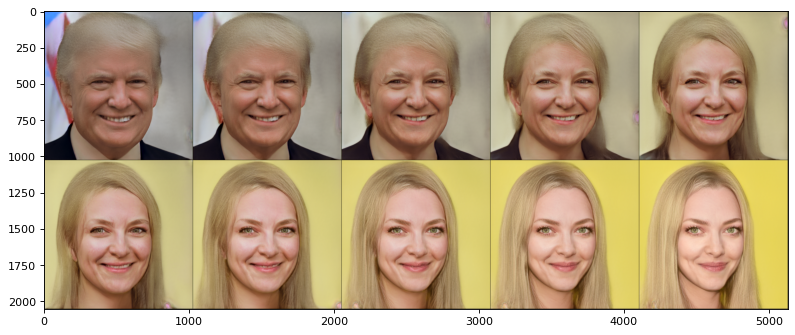

In [14]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./donald_trump_01_latent.npy')
w_2 = np.load('./amanda_seyfried_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


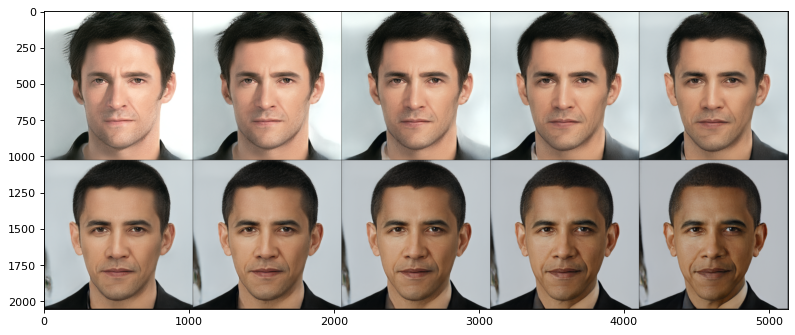

In [13]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./hugh_jackman_01_latent.npy')
w_2 = np.load('./barack_obama_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


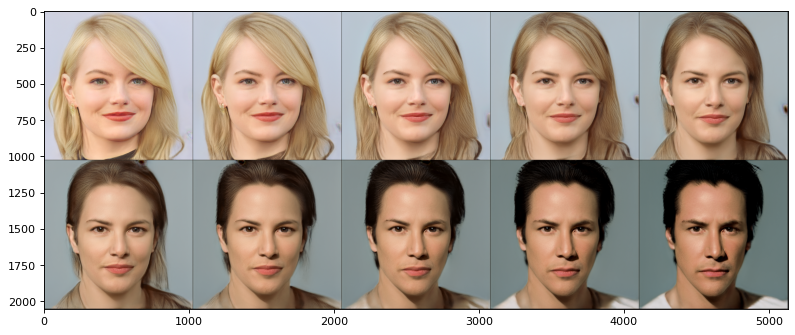

In [15]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./emma_stone_01_latent.npy')
w_2 = np.load('./keanu_reeves_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


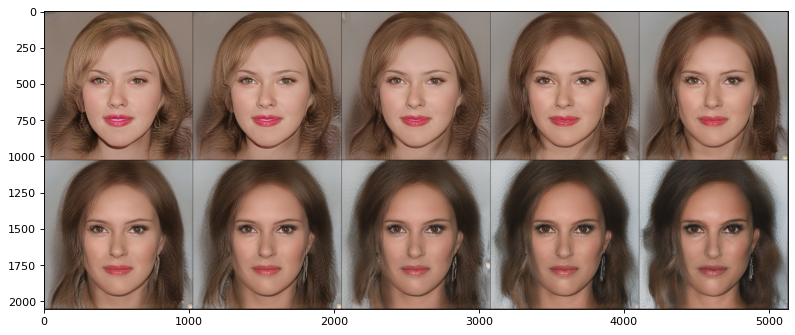

In [16]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./scarlett_johansson_01_latent.npy')
w_2 = np.load('./natalie_portman_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


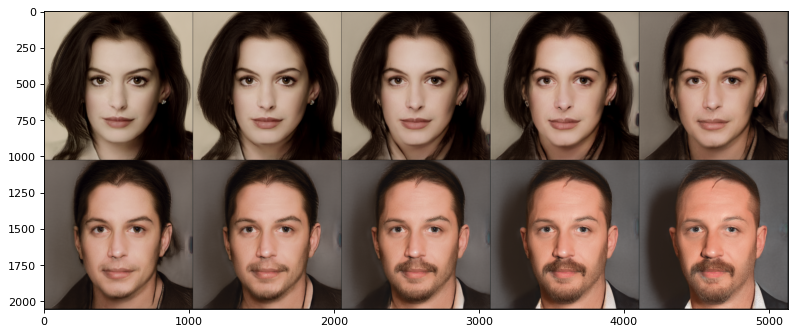

In [17]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./anne_hathaway_01_latent.npy')
w_2 = np.load('./tom_hardy_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


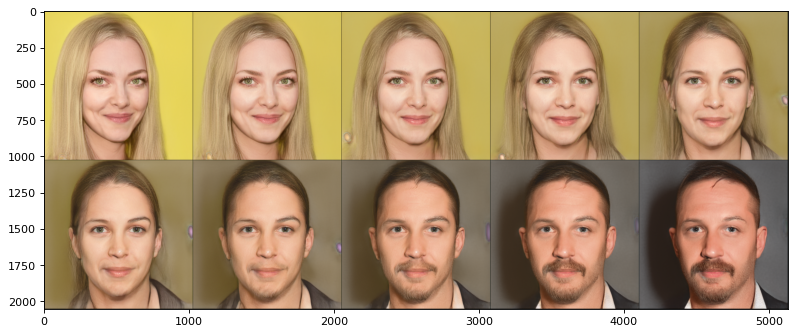

In [18]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./amanda_seyfried_01_latent.npy')
w_2 = np.load('./tom_hardy_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Face Interpolation ]


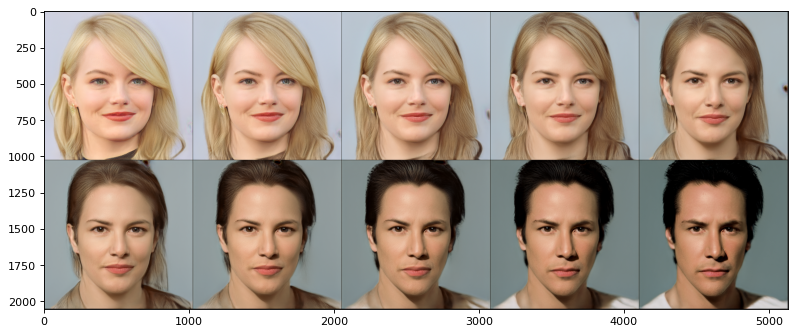

In [19]:
print('[ Face Interpolation ]')

# load w vectors from .npy files
w_1 = np.load('./emma_stone_01_latent.npy')
w_2 = np.load('./keanu_reeves_01_latent.npy')

name = 'interpolation'
interpolated_images = []

# face morphing
with torch.no_grad():
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w.unsqueeze(0))
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# save the result image
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)